# Regional Analyses

In [1]:
import os
import rasterio as rs
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd 
import pandas as pd

## Gut Checks on Stats

In [70]:
bel = pd.read_csv(f'Belize/stats/Belize_statistics.csv')
# check for nulls
bel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           990 non-null    object 
 1   admin             990 non-null    object 
 2   esa_id            990 non-null    float64
 3   esa_class         990 non-null    object 
 4   esa_sampled_ha    990 non-null    float64
 5   esa_total_ha      990 non-null    float64
 6   tree_cover_class  990 non-null    object 
 7   tof_ha            990 non-null    int64  
 8   hans_ha           990 non-null    int64  
 9   tof_mean          990 non-null    float64
 10  hans_mean         990 non-null    float64
dtypes: float64(5), int64(2), object(4)
memory usage: 85.2+ KB


In [71]:
bel.describe()

,esa_id,esa_sampled_ha,esa_total_ha,tof_ha,hans_ha,tof_mean,hans_mean
count,990.000000,990.000000,9.900000e+02,990.000000,990.000000,990.000000,990.000000
mean,115.131313,5762.973434,6.362020e+04,546.119192,2414.426263,28.199614,29.343684
std,74.441180,15270.694605,2.061768e+05,1939.523631,15759.051797,21.509161,22.698251
min,10.000000,0.000000,1.830000e+01,0.000000,0.000000,0.000000,4.500000
25%,40.000000,87.830000,7.143300e+02,5.000000,26.000000,13.502772,11.419357
50%,110.000000,563.420000,4.495410e+03,40.000000,178.500000,23.927916,21.366659
75%,180.000000,4147.540000,1.508296e+04,336.500000,914.750000,39.318481,40.612736
max,255.000000,120150.510000,1.709142e+06,26790.000000,284615.000000,88.545357,96.871315


In [72]:
# check class count and categories
print(bel.esa_class.nunique())
bel.esa_class.value_counts()

18


Cropland, rainfed                                                 130
Shrub or herbaceous cover, flooded, fresh/saline/brakish water     60
Shrubland                                                          60
Water bodies                                                       60
Tree cover, broadleaved, evergreen                                 60
No Data (flag)                                                     60
Mosaic cropland / natural vegetation                               60
Grassland                                                          60
Urban areas                                                        60
Mosaic herbaceous cover / tree and shrub                           60
Mosaic natural vegetation / cropland                               60
Tree cover, flooded, saline water                                  60
Mosaic tree and shrub / herbaceous cover                           60
Tree cover, broadleaved, deciduous                                 50
Bare areas          

In [73]:
# check if any of the means are > 100%
bel[bel.tof_mean >= 100]

,country,admin,esa_id,esa_class,esa_sampled_ha,esa_total_ha,tree_cover_class,tof_ha,hans_ha,tof_mean,hans_mean


In [74]:
# check if any of the means are > 100%
bel[bel.hans_mean >= 100]

,country,admin,esa_id,esa_class,esa_sampled_ha,esa_total_ha,tree_cover_class,tof_ha,hans_ha,tof_mean,hans_mean


In [75]:
# make sure mean != 0 if ha > 0
bel[(bel.tof_mean == 0) & (bel.tof_ha > 0)]

,country,admin,esa_id,esa_class,esa_sampled_ha,esa_total_ha,tree_cover_class,tof_ha,hans_ha,tof_mean,hans_mean


In [77]:
# in which esa classes is tof mean 0?
bel[bel.tof_mean == 0].esa_class.value_counts()

Bare areas                                                        20
Tree cover, flooded, fresh or brakish water                       20
Water bodies                                                      20
Tree cover, mixed leaf type                                       10
Shrub or herbaceous cover, flooded, fresh/saline/brakish water    10
Tree cover, flooded, saline water                                 10
Tree cover, needleleaved, deciduous                               10
Tree cover, broadleaved, deciduous                                10
Name: esa_class, dtype: int64

In [78]:
# check the no data class means
bel[bel.esa_class == 'No Data (flag)']

,country,admin,esa_id,esa_class,esa_sampled_ha,esa_total_ha,tree_cover_class,tof_ha,hans_ha,tof_mean,hans_mean
160,Belize,Toledo,255.0,No Data (flag),87.83,507275.18,0-9,43,1229,59.946999,58.740467
161,Belize,Toledo,255.0,No Data (flag),87.83,507275.18,10-19,13,270,59.946999,58.740467
162,Belize,Toledo,255.0,No Data (flag),87.83,507275.18,20-29,8,210,59.946999,58.740467
163,Belize,Toledo,255.0,No Data (flag),87.83,507275.18,30-39,4,204,59.946999,58.740467
164,Belize,Toledo,255.0,No Data (flag),87.83,507275.18,40-49,13,218,59.946999,58.740467
165,Belize,Toledo,255.0,No Data (flag),87.83,507275.18,50-59,14,205,59.946999,58.740467
166,Belize,Toledo,255.0,No Data (flag),87.83,507275.18,60-69,15,212,59.946999,58.740467
167,Belize,Toledo,255.0,No Data (flag),87.83,507275.18,70-79,9,214,59.946999,58.740467
168,Belize,Toledo,255.0,No Data (flag),87.83,507275.18,80-89,12,235,59.946999,58.740467
169,Belize,Toledo,255.0,No Data (flag),87.83,507275.18,90-99,21,1218,59.946999,58.740467


In [ ]:
# does the no data class have 0 tree cover
es[es.esa_class == 'No Data (flag)']

In [61]:
# check each lc in each admin - where does sampled = total?
es = es[['country', 'admin', 'esa_class', 'esa_sampled_ha', 'esa_total_ha']]
es = es.drop_duplicates(keep='first', ignore_index=True)
es[es.esa_sampled_ha == es.esa_total_ha]

,country,admin,esa_class,esa_sampled_ha,esa_total_ha
34,El Salvador,San Salvador,Mosaic herbaceous cover / tree and shrub,9.30,9.30
35,El Salvador,San Salvador,Shrubland,9.00,9.00
48,El Salvador,San Miguel,Mosaic herbaceous cover / tree and shrub,82.21,82.21
49,El Salvador,San Miguel,Shrubland,45.90,45.90
51,El Salvador,San Miguel,"Tree cover, flooded, fresh or brakish water",36.30,36.30
53,El Salvador,San Miguel,"Shrub or herbaceous cover, flooded, fresh/sali...",355.82,355.82
55,El Salvador,San Miguel,Bare areas,437.11,437.11
64,El Salvador,San Vicente,"Tree cover, mixed leaf type",18.30,18.30
65,El Salvador,San Vicente,Mosaic tree and shrub / herbaceous cover,54.90,54.90
66,El Salvador,San Vicente,Grassland,736.83,736.83


## Create Regional Spreadsheets
Combines country stats spreadsheets into one csv for the region.

In [3]:
def create_regional_csv(list_of_countries, region):
    
    regional_df = pd.DataFrame()
    dfs_to_concat = []
    
    for country in list_of_countries:
        country_df = pd.read_csv(f'{country}/stats/{country}_statistics.csv')
        dfs_to_concat.append(country_df)
    
    regional_df = pd.concat(dfs_to_concat, ignore_index=True)
    regional_df.to_csv(f'regional_stats/{region}.csv', index=False)
    
    return None

In [4]:
create_regional_csv(['Belize', 'El Salvador', 'Guatemala', 'Honduras', 'Nicaragua', 'Panama', 'Costa Rica'], 
                    'central_am')

In [18]:
create_regional_csv(['Rwanda', 'Burundi'], 'east_afr')

## Sampling Area: Country
This barchart illustrates the sampling coverage for each land cover class in a country. Each bar shows the sampled and total hectares of each land cover class in hectares (any hectare containing >0% tree cover is included). The results are sorted by hectares of land cover sampled in ascending order.

In [16]:
def lc_sampled(country):
    
    df = pd.read_csv(f'{country}/stats/{country}_statistics.csv')
    df = df[['country', 'admin', 'esa_class', 'esa_sampled_ha', 'esa_total_ha']]
    
    df = df.drop_duplicates(keep='first', ignore_index=True)
    df['esa_not_sampled'] = df['esa_total_ha'] - df['esa_sampled_ha']
    df = df.groupby(by='esa_class').sum().reset_index()
    df = df.sort_values(by='esa_sampled_ha')
    df['esa_perc_sampled'] = round((df['esa_sampled_ha'] / df['esa_total_ha']) * 100)

    
    # create the visualization
    plt.figure(figsize=(10,5))
    classes = list(df.esa_class.values)
    bars1 = df.esa_sampled_ha
    bars2 = df.esa_not_sampled

    plt.barh(classes, bars1, color="#f3e151", label='sampled')  
    plt.barh(classes, bars2, left=bars1, color="#6c3376", label='not sampled')

    plt.title(f'Land Cover Sampled in {country}')
    plt.xlabel('Tree Cover (ha)')
    plt.ticklabel_format(useOffset=False, style='plain', axis='x')
    plt.grid(axis='x', linestyle='-', linewidth=.2)
    plt.legend();
    
    return

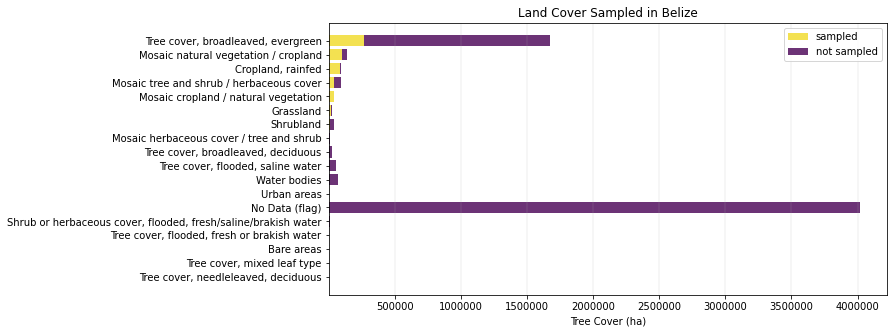

In [40]:
lc_sampled('Belize')

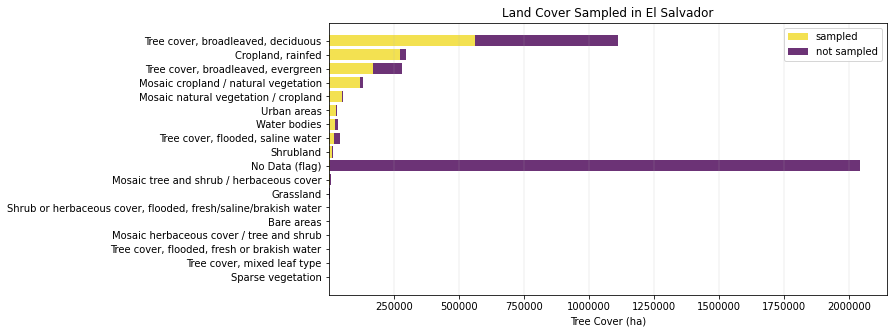

In [62]:
lc_sampled('El Salvador')

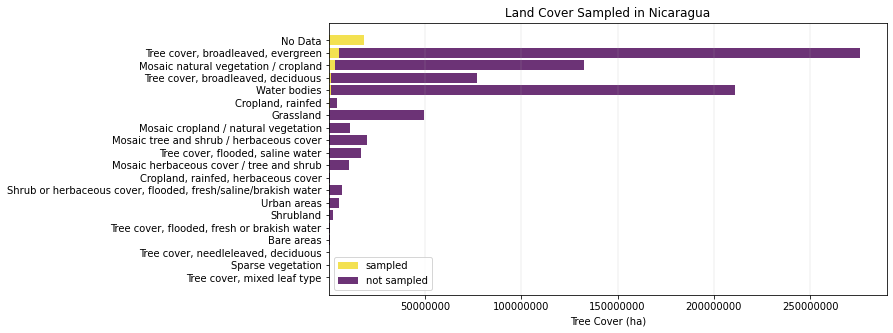

In [25]:
# old
lc_sampled('Nicaragua')

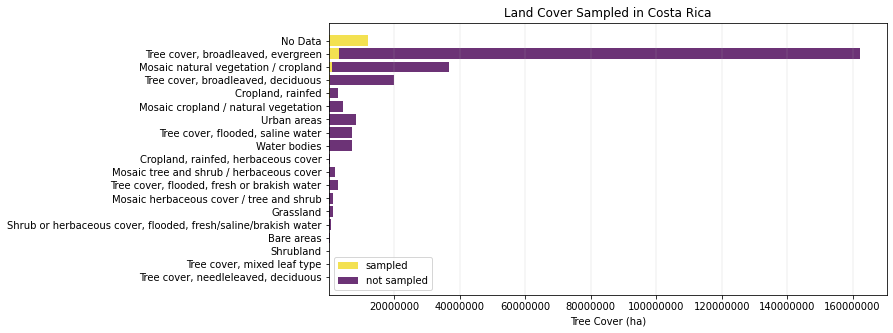

In [6]:
lc_sampled('Costa Rica')

## Top 5 Admins with Trees on Farms
This function returns the top five administrative districts with tree cover on agriculture land cover types.   

It addresses two questions:  
Which admins have the highest mean tree cover in agricultural areas?  
Which admins have the most hectares of tree cover in agricultural areas?  

To compare one admin district to another with unequal sampling we need to account for the % of the sampling area.
- Admin 1: 35%  of farms have >30% cover, 95% of farms sampled. Use the diagram I made above... say we get 32-38% confidence intervals
- Admin 2: 40% of farms have >30% cover, 30% of farms sampled. Here we might have a much wider confidence interval
- Admin 3: No data. No cropland in the admin district. Here we can be confident in the 0% of farms (no farms) having tree cover.



In [9]:
def trees_on_farms(region):
    
    '''
    Filters dataframe to the following ESA agriculture land cover types:
    
    Cropland, rainfed
    Cropland, rainfed, herbaceous cover
    Cropland, irrigated or post-flooding
    Mosaic cropland / natural vegetation
    Mosaic natural vegetation / cropland 
    
    Calculates the total ha tree cover per admin AND the avg % tree cover per admin.
    Merges the dataframes to include % of land cover class sampled and then builds
    two separate dataframes of top 5 cities in the region with highest stats.
    
    '''
    
    df = pd.read_csv(f'regional_stats/{region}.csv')
    
    # filter to only ag land cover classes
    ag_ids = [10.0, 11.0, 20.0, 30.0, 40.0]
    df = df[df.esa_id.isin(ag_ids)]

    # get total (sum) ha tree cover in ag for each admin
    df_ha = df.groupby(by=['country', 'admin']).sum().reset_index() 
    df_ha = df_ha[['country', 'admin', 'esa_sampled_ha', 'esa_total_ha','tof_ha']] 
    
    # add column with % of land cover class that was sampled
    df_ha['esa_perc_samp'] = round((df_ha.esa_sampled_ha / df_ha.esa_total_ha) * 100, 2)

    # now use original dataframe to get average tree cover in ag for each admin
    df_avg = df.groupby(by=['country','admin']).mean().reset_index()
    df_avg = df_avg[['country', 'admin', 'tof_mean']]
    
    # merge dataframes
    df_merged = pd.merge(df_ha, df_avg, how='inner', left_on=['country','admin'], right_on=['country','admin'])
    
    # sort and print top 5 ag areas
    top_5_ha = df_merged.sort_values(['tof_ha', 'esa_perc_samp'], ascending=(False, False))[:5]
    top_5_avg = df_merged.sort_values(['tof_mean', 'esa_perc_samp'], ascending=(False, False))[:5]
    
    print('Top 5 Admins with Trees on Farms (total hectares tree cover)')
    for i in top_5_ha.index:
        print(f'{top_5_ha.esa_perc_samp[i]}% of farms were sampled in {top_5_ha.admin[i]}, ' \
              f'{top_5_ha.country[i]} with {top_5_ha.tof_ha[i]} ha of tree cover >0%.')
    
    print(' ')
    print('Top 5 Admins with Trees on Farms (average % tree cover)')
    for i in top_5_avg.index:
        print(f'{top_5_avg.esa_perc_samp[i]}% of farms were sampled in {top_5_avg.admin[i]}, ' \
              f'{top_5_avg.country[i]} with {round(top_5_avg.tof_mean[i], 0)}% average tree cover.')

    return df_merged

In [10]:
central_am = trees_on_farms('central_am')

Top 5 Admins with Trees on Farms (total hectares tree cover)
3.61% of farms were sampled in Petén, Guatemala with 1807682 ha of tree cover >0%.
2.52% of farms were sampled in Atlántico Sur, Nicaragua with 1243489 ha of tree cover >0%.
2.54% of farms were sampled in Atlántico Norte, Nicaragua with 574631 ha of tree cover >0%.
2.96% of farms were sampled in Veraguas, Panama with 571099 ha of tree cover >0%.
3.01% of farms were sampled in Chontales, Nicaragua with 557226 ha of tree cover >0%.
 
Top 5 Admins with Trees on Farms (average % tree cover)
2.5% of farms were sampled in Ocotepeque, Honduras with 57.0% average tree cover.
2.8% of farms were sampled in El Progreso, Guatemala with 52.0% average tree cover.
3.85% of farms were sampled in Sacatepéquez, Guatemala with 48.0% average tree cover.
2.93% of farms were sampled in Boaco, Nicaragua with 44.0% average tree cover.
2.72% of farms were sampled in Madriz, Nicaragua with 43.0% average tree cover.


## Top 5 Cities with Urban Trees
This function highlights the top five administrative districts in a region with most tree cover in urban land cover types. It addresses two questions:  
Which admins have the highest mean tree cover in urban areas?  
Which admins have the most hectares of tree cover in urban areas?  

In [73]:
def trees_in_cities(region):
    
    '''
    Filters dataframe to the ESA urban land cover class. 
    
    Calculates the total ha tree cover per admin or the comb avg  % tree cover per admin,
    then sorts values in descending order to get top 5 admins.
    
    '''
    
    df = pd.read_csv(f'regional_stats/{region}.csv')
    
    # filter to only urban land cover class
    df = df[df.esa_id == 190.0]
    
    # get total (sum) ha tree cover in urban class for each admin
    df_ha = df.groupby(by=['country', 'admin']).sum().reset_index() 
    df_ha = df_ha[['country', 'admin', 'esa_sampled_ha', 'esa_total_ha','tof_ha']] 
    
    # add column with % of land cover class that was sampled
    df_ha['esa_perc_samp'] = round((df_ha.esa_sampled_ha / df_ha.esa_total_ha) * 100, 2)

    # now use original dataframe to get average tree cover in urban class for each admin
    df_avg = df.groupby(by=['country','admin']).mean().reset_index()
    df_avg = df_avg[['country', 'admin', 'tof_mean']]
    
    # merge dataframes
    df_merged = pd.merge(df_ha, df_avg, how='inner', left_on=['country','admin'], right_on=['country','admin'])
    
    # sort and print top 5 urban areas
    top_5_ha = df_merged.sort_values(['tof_ha', 'esa_perc_samp'], ascending=(False, False))[:5]
    top_5_ha = top_5_ha.reset_index().drop('index', 1)
    top_5_avg = df_merged.sort_values(['tof_mean', 'esa_perc_samp'], ascending=(False, False))[:5]
    top_5_avg = top_5_avg.reset_index().drop('index', 1)

    
    print('Top 5 Cities with Trees (total hectares tree cover)')
    for i in top_5_ha.index:
        print(f'{top_5_ha.esa_perc_samp[i]}% of urban areas were sampled in {top_5_ha.admin[i]}, ' \
              f'{top_5_ha.country[i]} with {top_5_ha.tof_ha[i]} ha of tree cover >0%.')
    
    print(' ')
    print('Top 5 Cities with Trees (average % tree cover)')
    for i in top_5_avg.index:
        print(f'{top_5_avg.esa_perc_samp[i]}% of urban areas were sampled in {top_5_avg.admin[i]}, ' \
              f'{top_5_avg.country[i]} with {round(top_5_avg.tof_mean[i], 0)}% average tree cover.')
        
    # display top 5 ha
    num1 = rs.open(f'{top_5_ha.country[0]}/resampled_rasters/tof/{top_5_ha.admin[0]}.tif').read(1)
    num2 = rs.open(f'{top_5_ha.country[1]}/resampled_rasters/tof/{top_5_ha.admin[1]}.tif').read(1)
    
    plt.figure(figsize=(30,20))

    plt.subplot(1,2,1)
    plt.imshow(num1, cmap='Greens', vmin=0, vmax=100)
    plt.title(f'#1: {top_5_ha.admin[0]}, {top_5_ha.country[0]} (ha tree cover)')

    plt.subplot(1,2,2)
    plt.imshow(num2, cmap='Greens', vmin=0, vmax=100)
    plt.title(f'#2: {top_5_ha.admin[1]}, {top_5_ha.country[1]} (ha tree cover)')

    # figure out where in that admin has the highest tree cover by lat/lon coordinates?
    # long term could scale down to admin 2 level in these areas?

    return None

Top 5 Cities with Trees (total hectares tree cover)
0.53% of urban areas were sampled in Guatemala, Guatemala with 30657 ha of tree cover >0%.
0.53% of urban areas were sampled in San José, Costa Rica with 19667 ha of tree cover >0%.
0.53% of urban areas were sampled in Panamá, Panama with 17391 ha of tree cover >0%.
0.53% of urban areas were sampled in Quezaltenango, Guatemala with 16388 ha of tree cover >0%.
0.53% of urban areas were sampled in Cortés, Honduras with 15108 ha of tree cover >0%.
 
Top 5 Cities with Trees (average % tree cover)
0.53% of urban areas were sampled in Usulután, El Salvador with 36.0% average tree cover.
0.53% of urban areas were sampled in Madriz, Nicaragua with 36.0% average tree cover.
0.53% of urban areas were sampled in El Progreso, Guatemala with 34.0% average tree cover.
0.53% of urban areas were sampled in La Libertad, El Salvador with 33.0% average tree cover.
0.53% of urban areas were sampled in San Salvador, El Salvador with 32.0% average tree cov

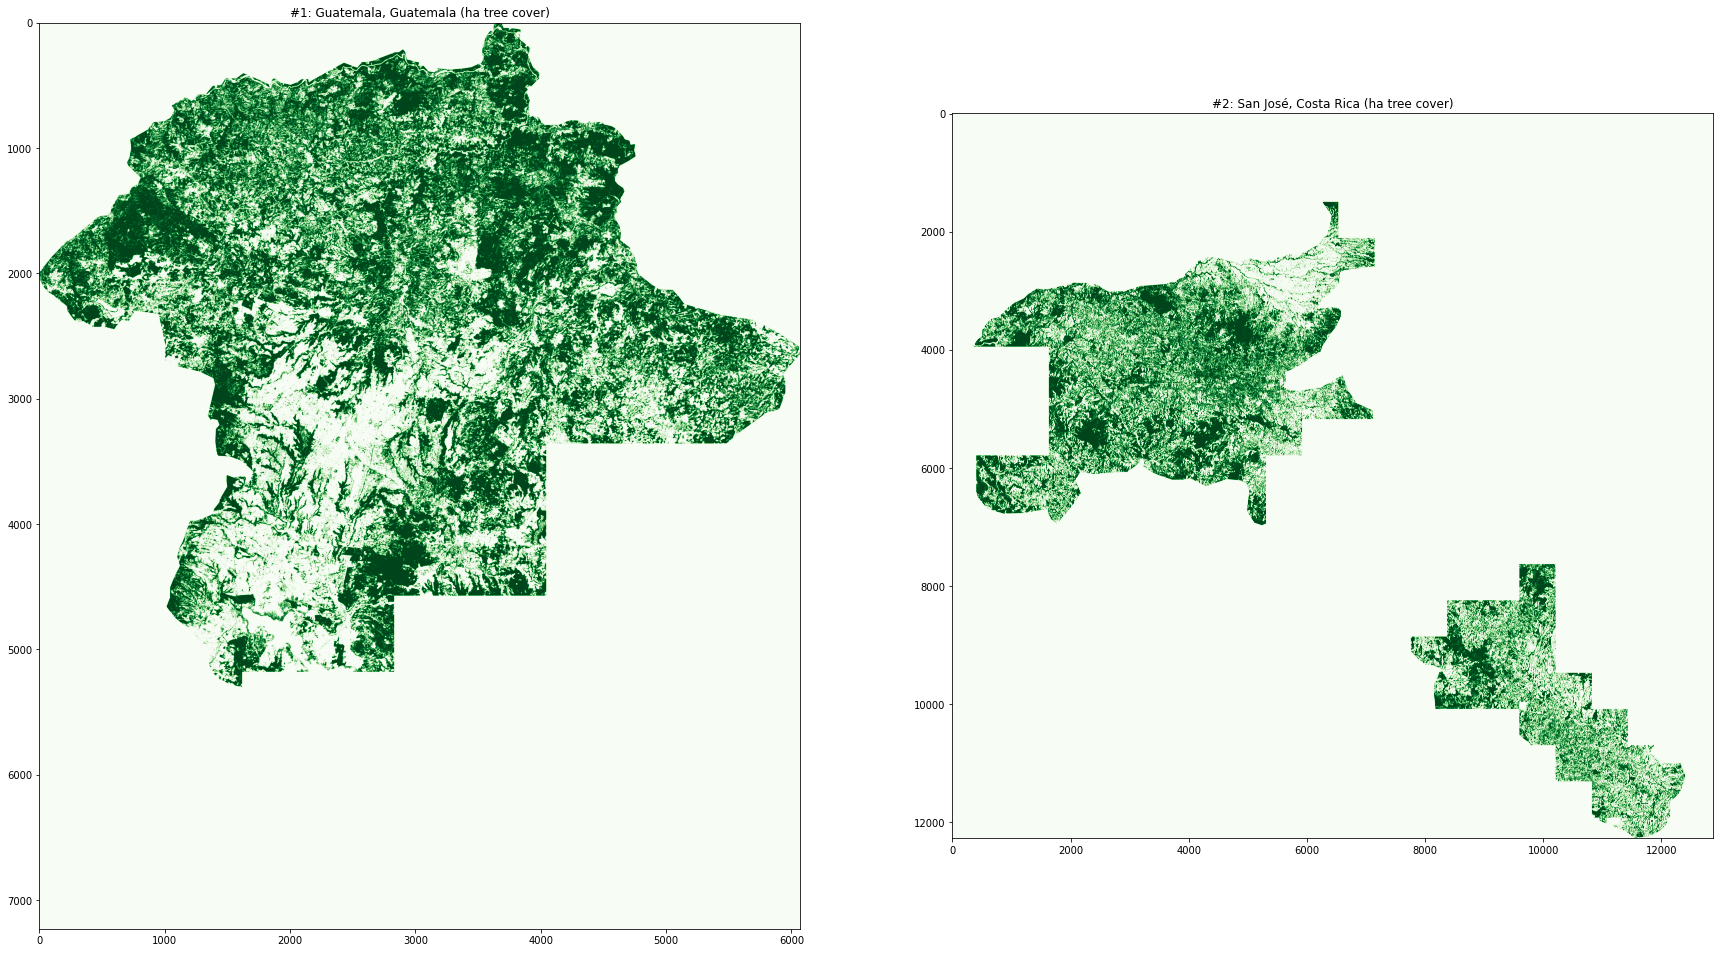

In [74]:
central_am_cities = trees_in_cities('central_am')

In [70]:
central_am_cities.country[0]

'Guatemala'

## Ag/Urban Areas Meeting Forest Cover Definition (>10%)
The FAO defines Forest as a land area of more than 0.5 ha, with a tree canopy cover of more than 10%, which is not primarily under agricultural or other specific non-forest land use. This visualization illustrates the tree cover in agriculture and urban areas that qualifies as forest under this definition. The yellow portion indicates the percentage of tree cover that is not compliant (<10%) and the purple portion indicates the percentage of tree cover that is compliant (>10%).

30-70% of tree cover on farms and in urban areas in Central American meet forest cover definitions.

In [32]:
def forest_cover_compliant(region, figsize):
    
    region_df = pd.read_csv(f'regional_stats/{region}.csv')
    
    countries = list(set(region_df.country.values))

    x_labels = []
    bar1 = []
    bar2 = []

    for country in countries:
        
        # filter to one country and only urban/ag land cover classes
        country_df = region_df[region_df.country == country]
        ids = [10.0, 11.0, 20.0, 30.0, 40.0, 190.0]
        country_df = country_df[country_df.esa_id.isin(ids)]
        
        # get total tof ha per tree cover threshold
        country_df = country_df.groupby(by=['country', 'tree_cover_class']).sum().reset_index() 
        country_df = country_df[['country', 'tree_cover_class', 'tof_ha']] 
        
        # calculate # ha <10% tree cover and >10% tree cover
        under10 = country_df.tof_ha[0]
        over10 = sum(country_df.tof_ha[1:])
        
        # normalize
        total = under10 + over10
        under10_norm = under10/total*100
        over10_norm = over10/total*100
        
        x_labels.append(country)
        bar1.append(under10_norm)
        bar2.append(over10_norm)
   
    # convert to array in order to add data labels
    bar1 = np.asarray(bar1)
    bar2 = np.asarray(bar2)
    
    # create the figure
    plt.figure(figsize=figsize)
    plt.bar(x_labels, bar1, color="#f3e151", label='<10% cover')  
    plt.bar(x_labels, bar2, bottom=bar1, color="#6c3376", label='>10% cover')    
    
    # labels
    for xpos, ypos, yval in zip(x_labels, bar1/2, bar1):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    for xpos, ypos, yval in zip(x_labels, bar1 + bar2/2, bar2):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    
    plt.xlabel(' ')
    plt.ylabel('% Tree Cover')
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(f'% Ag & Urban Trees Meeting Forest \n Cover Definition in {region}')
    plt.legend(); 

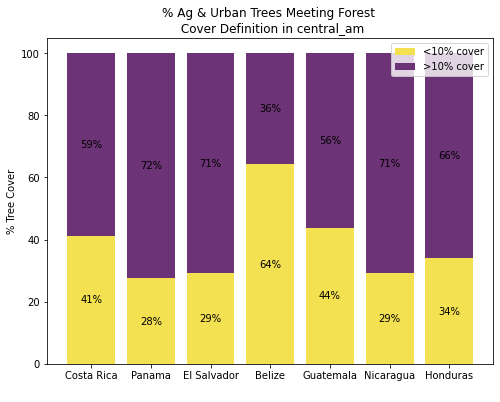

In [33]:
forest_cover_compliant('central_am', (8,6))

In [ ]:
# across the region, which admins have the greates

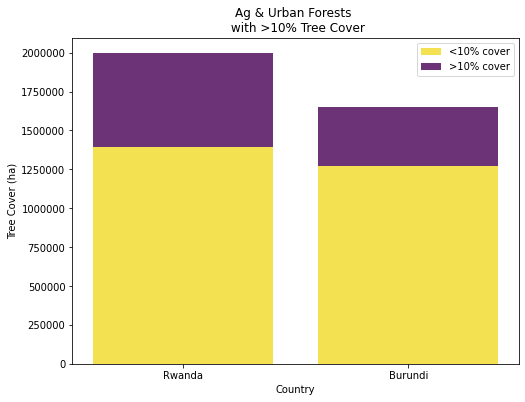

In [15]:
forest_cover_compliant('east_afr', (8,6))

## Top 5 Admins with Fragmented Forests
Clarification: are we calculating the number of admins with the "most" fragmented forests and what does that mean?
- fragmented forest: the area of forest within one pixel of the edge
- forest connectivity: the area of disconnected forest fragments

Could replicate the approach used by [Cunningham et al. 2020](https://www.mdpi.com/2072-4292/12/19/3226/htm) and use the Guidos Toolbox [MSPA (Morphological Spatial Pattern Analysis)](https://forest.jrc.ec.europa.eu/en/activities/lpa/mspa/)
- Soille P, Vogt P, 2009. Morphological segmentation of binary patterns. Pattern Recognition Letters 30, 4:456-459, DOI: 10.1016/j.patrec.2008.10.015 

OpenForis example implementation - python?: https://github.com/openforis/mspa-analysis/blob/master/scripts/mspa.py

## Tree Cover Distribution: Regional Comparisons
This grouped barchart compares tree cover distribution in 10% canopy cover thresholds across four regions: Central America, East Africa, West Africa, Sahel). (In the future could consider a facet grid that illustrates the distribution in a barchart per country)

In [19]:
def tree_cover_distribution(central_am, east_afr):
    
    # later will be updated to compare across 4 regions
    #central_am = pd.read_csv('regional_stats/central_am.csv')
    #east_afr = pd.read_csv('regional_stats/east_afr.csv')
    #west_afr = pd.read_csv('regional_stats/west_afr.csv')
    #sahel = pd.read_csv('regional_stats/sahel.csv')

    central_am = central_am.groupby(by=['tree_cover_class']).sum().reset_index() 
    central_am = central_am[['tree_cover_class', 'tof_ha']]

    east_afr = east_afr.groupby(by=['tree_cover_class']).sum().reset_index() 
    east_afr = east_afr[['tree_cover_class', 'tof_ha']]

    labels = list(central_am.tree_cover_class)
    x = np.arange(len(labels))  # the label locations
    width = 0.35  

    plt.figure(figsize=(10,8))
    plt.bar(x - width/2, central_am.tof_ha, width, label='Central America')
    plt.bar(x + width/2, east_afr.tof_ha, width, label='East Africa')

    plt.title('Tree Cover Distribution by Region')
    plt.xlabel('Thresholds (%)')
    plt.ylabel('Total Ha')
    plt.xticks(x, labels=labels)
    plt.ticklabel_format(style='plain', axis='y')
    plt.grid(axis='y', linestyle='-', linewidth=.2)
    plt.legend();
    
    return None

In [20]:
central_am = pd.read_csv('regional_stats/central_am.csv')
east_afr = pd.read_csv('regional_stats/east_afr.csv')

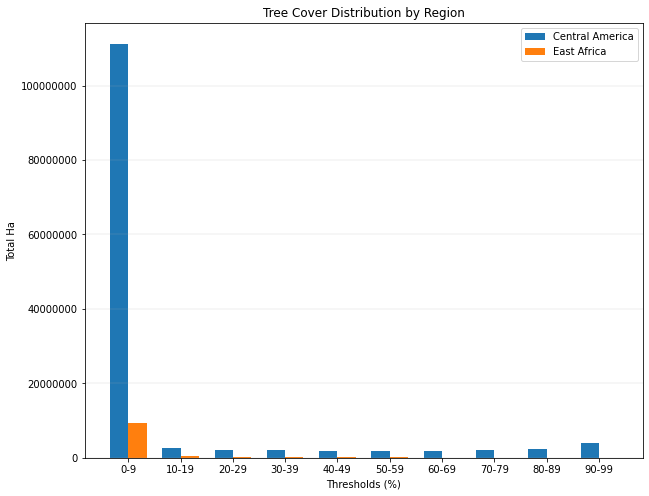

In [21]:
tree_cover_distribution(central_am, east_afr)